# Calculate  optimal extraction error due to cross-dispersion shift

### Gaussian input

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,u'Flux per pixel (1D only)')

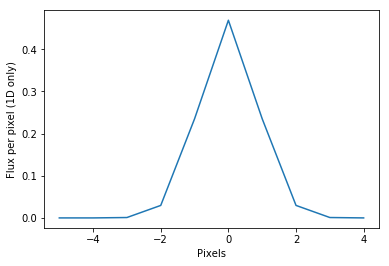

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

FWHM = 2
sig=FWHM/2.35
flux = 1 
x = np.arange(-5,5,1)
gaussian_model = flux*np.exp(-x**2/2./sig**2)/sig/np.sqrt(2.*np.pi)
plt.plot(x,gaussian_model)
plt.xlabel('Pixels')
plt.ylabel('Flux per pixel (1D only)')


### Construct gaussian matched filter, offset by some amount

In [20]:
offset = 0.1
matched_filter = np.exp(-(x-offset)**2/2./sig**2)/sig/np.sqrt(2.*np.pi)
matched_filter /= np.sum(matched_filter**2)
print("Testing matched filter: measured:",np.sum(gaussian_model*matched_filter)," input: ",flux)

('Testing matched filter: measured:', 0.99677660015688285, ' input: ', 1)


In [21]:
matched_filter = np.exp(-(x-offset)**2/2./sig**2)/sig/np.sqrt(2.*np.pi)
print np.sum(matched_filter**2)

0.331882884126


### Do this for a range of offsets

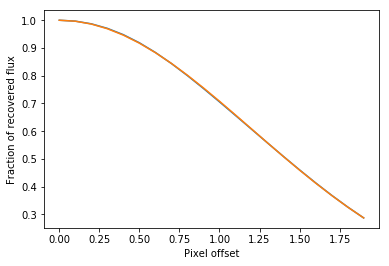

In [3]:
offsets = np.arange(0.0,2.,0.1)
measured_values = np.zeros(len(offsets))
for i in range(len(offsets)):
    offset = offsets[i]
    matched_filter = np.exp(-(x-offset)**2/2./sig**2)/sig/np.sqrt(2.*np.pi)
    matched_filter /= np.sum(matched_filter**2)
    measured_values[i] = np.sum(gaussian_model*matched_filter)

plt.plot(offsets,measured_values/flux)
plt.xlabel("Pixel offset")
plt.ylabel("Fraction of recovered flux")
mf = np.exp(-(offsets)**2/2./sig**2/2.)
plt.plot(offsets,mf)

## Do this in 2D

[ 0.09560103  0.15640978  0.10811484  0.17688322]
[ 0.17802505  0.29126107  0.20132785  0.32938603]
0.265553988831


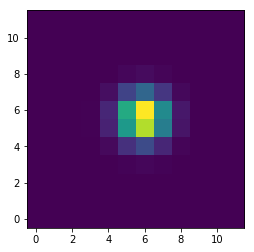

In [4]:
from scipy.special import erf
size = 12
# add some static offset to reflect arbitrary sampling
_x = np.arange(size)-size//2+0.1
_y = np.arange(size)-size//2+0.4
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet /= np.sum(psflet)
psflet*=flux

plt.imshow(psflet)
print psflet[psflet/np.amax(psflet)>0.5]
f = psflet[psflet/np.amax(psflet)>0.5]
f /= np.sum(f)
print f
print (np.sum(f**2))

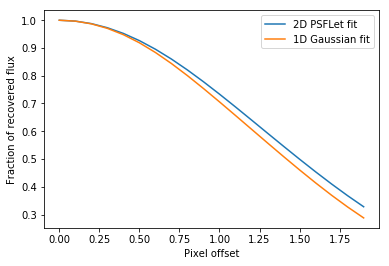

In [5]:
offsets = np.arange(0.0,2.,0.1)
measured_values_psflet = np.zeros(len(offsets))
for i in range(len(offsets)):
    offset = offsets[i]
    matched_filter = (erf((_x + 0.5-offset) / (np.sqrt(2) * sigma)) - \
                            erf((_x - 0.5-offset) / (np.sqrt(2) * sigma))) * \
                            (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
                            erf((_y - 0.5) / (np.sqrt(2) * sigma)))
    matched_filter /= np.sum(matched_filter)
    matched_filter /= np.sum(matched_filter**2)
    measured_values_psflet[i] = np.sum(psflet*matched_filter)
    
plt.plot(offsets,measured_values_psflet/flux)
plt.xlabel("Pixel offset")
plt.ylabel("Fraction of recovered flux")
plt.plot(offsets,measured_values)
plt.legend(["2D PSFLet fit","1D Gaussian fit"])
# mf = np.exp(-(offsets)**2/2./sig**2/2.)
#plt.plot(offsets,mf)

# Study the number of effective detector pixels

In [6]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
from scipy.special import erf
def psf(fwhm=2.,dx=0.,dy=0.,sizex=10,sizey=10):
    _x = np.arange(sizex)-sizex//2+dx
    _y = np.arange(sizey)-sizey//2+dy
    _x, _y = np.meshgrid(_x, _y)
    sigma = fwhm/2.35
    psflet = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

    return psflet/np.sum(psflet)

Populating the interactive namespace from numpy and matplotlib


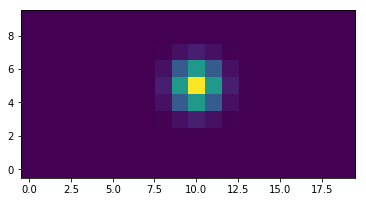

In [7]:
plt.imshow(psf(sizey=10,sizex=20))

## Construct microspectrum

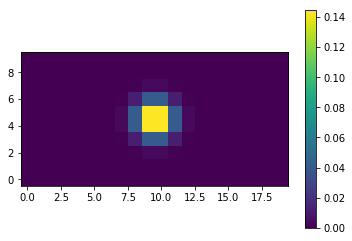

In [8]:
dy=0.5
dxmin = 0.5
microspec = psf(sizey=10,sizex=20,dy=dy,dx=dxmin)
dxlist = np.arange(dxmin)
plt.imshow(microspec)
plt.colorbar()

### Equivalent noise pixel computation for matched filtering

In [12]:
dy=0.2
dxmin = 0.2
p = psf(sizex=100,sizey=100,dy=dy,dx=dxmin)
p[p<np.amax(p)/2.]=0.0
print(np.sum(p)**2/np.sum(p**2))
V = np.sum(p)
sharpness = np.sum(p**2/V**2)
beta = 1./sharpness
print beta

2.90257591762
2.90257591762


In [15]:
N = 10000
vals=np.zeros(N)
dxlist = np.zeros(N)
dylist = np.zeros(N)

for i in range(N):
    dylist[i] = np.random.uniform(-0.5,0.5)
    dxlist[i] = np.random.uniform(-0.5,0.5)
    p = psf(sizex=20,sizey=20,dy=dylist[i],dx=dxlist[i])
    #p[p<np.amax(p)/2.]=0.0
    vals[i] = 1./np.sum(p**2)


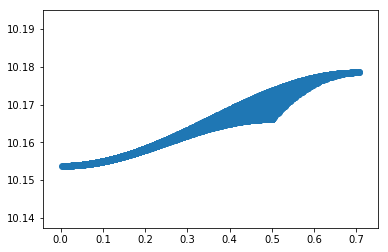

In [16]:
plt.scatter(np.sqrt(dylist**2+dxlist**2),vals)
# do colorgrid

### Aperture photometry

### signal within 2x2 pixel aperture